In [1]:
%matplotlib notebook
from __future__ import print_function
import os,sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import torch
import torchvision
import scipy
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [2]:
def np_loader(inp):

    with open(inp, 'rb') as f:

        npin = np.load(f)

        return npin

def rotated(inp,angles):
    r = R.from_euler('zyx', angles, degrees=True).as_matrix()
    #print(torch.tensor(r))
    return torch.matmul(inp,torch.tensor(r,dtype=torch.half))

In [3]:
datadirectoy = "../PilarDataTest"

In [4]:
a = np_loader(datadirectoy+"/Electron/000001.npy")

In [5]:
dataset = torchvision.datasets.DatasetFolder(root=datadirectoy, loader=np_loader, extensions='.npy')

In [6]:
print(dataset)

Dataset DatasetFolder
    Number of datapoints: 285369
    Root location: ../PilarDataTest


In [7]:
class SparseToFull(object):
    """Change from sparse data format to a full 3D image.
    Args:
        imagesize (L x W x H): Size of full image
    """

    def __init__(self, imagesize = (512,512,512)):
        super().__init__()
        assert isinstance(imagesize,tuple)
        assert len(imagesize) == 3
        self.imagesize = imagesize

    def __call__(self, tensor):
        """
        Args:
            tensor to be changed to dense.
        Returns:
            Tensor: tensor in dense form.
        """
        indices = tensor[:,:-1].T
        values = tensor[:,-1].T
        tensorinput = torch.sparse_coo_tensor(indices, values, self.imagesize, dtype=torch.float32)
        tensordense = tensorinput.to_dense()
        denseunsqueeze = torch.unsqueeze(tensordense,dim=0)
        
        return denseunsqueeze

In [11]:
test_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=True,
        num_workers = 8, 
        pin_memory = True)
print(dataset.class_to_idx)

{'Electron': 0, 'Gamma': 1, 'Muon': 2, 'Pion': 3, 'Proton': 4}


In [12]:
classes = dataset.class_to_idx
invclasses = {v: k for k, v in classes.items()}

In [10]:
one = torch.tensor([0]).cuda()
charges = {0: one.clone(), 1: one.clone(), 2: one.clone(), 3: one.clone(), 4: one.clone()}
sizes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
lengths = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

In [11]:
chargestotal = []
sizestotal = []
lengthstotal = []

In [12]:
charges = {0: one.clone(), 1: one.clone(), 2: one.clone(), 3: one.clone(), 4: one.clone()}
sizes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
lengths = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

for idx, batch in enumerate(test_loader):
    print(idx,end="\r")
    label = int(batch[1])
    data = batch[0][0].cuda()
    ch = data[:,-1]
    charges[label]=torch.cat((charges[label],ch))
    sizes[label]+=1
    lengths[label]+=len(ch)
    if idx%1000==0:
        chargestotal.append(charges)
        sizestotal.append(sizes)
        lengthstotal.append(lengths)
        charges = {0: one.clone(), 1: one.clone(), 2: one.clone(), 3: one.clone(), 4: one.clone()}
        sizes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        lengths = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    if idx==100000:
        break

KeyboardInterrupt: 

In [24]:
pool=torch.nn.AvgPool3d((3,3,3),stride=(3,3,3),divisor_override=1).cuda()

In [93]:
testtensor = torch.tensor([[1,2,3,5],
                          [1,2,4,7],
                          [1,1,3,5],
                          [1,1,9,10]]
                         )
# print(full(testtensor)[0][1][2])
print(pool(full(testtensor)))

tensor([[[[ 0., 17.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

         ...,

         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  

In [37]:
charges = {0: one.clone(), 1: one.clone(), 2: one.clone(), 3: one.clone(), 4: one.clone()}
sizes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
lengths = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
full = SparseToFull()

for idx, batch in tqdm(enumerate(test_loader)):
    print(idx,end="\r")
    label = int(batch[1])
    data = batch[0][0].cuda()
    fulldata = full(data)
    pooleddata = pool(fulldata)
    nonzero = torch.nonzero(pooleddata,as_tuple=True)
    ch = pooleddata[nonzero]
    charges[label]=torch.cat((charges[label],ch))
    sizes[label]+=1
    lengths[label]+=len(ch)
    if idx%1000==0:
        chargestotal.append(charges)
        sizestotal.append(sizes)
        lengthstotal.append(lengths)
        charges = {0: one, 1: one, 2: one, 3: one, 4: one}
        sizes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        lengths = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    if idx==100000:
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


In [13]:
ed, ld = sizes.copy(), sizes.copy()
for i in sizestotal:
    for x,v in i.items():
        ed[x]+=v
for i in lengthstotal:
    for x,v in i.items():
        ld[x]+=v
print(ed)
print(ld)

{0: 24442, 1: 13641, 2: 14782, 3: 5671, 4: 19576}
{0: 36593150, 1: 17266024, 2: 28482625, 3: 5689178, 4: 9037767}


In [14]:
cd = charges.copy()
for i in chargestotal:
    for x,v in i.items():
        cd[x] = torch.cat((cd[x],v[v!=0]))

In [15]:
for x,v in cd.items():
    cd[x] = cd[x].cpu().numpy()
print(cd)

{0: array([0.     , 0.01327, 0.01272, ..., 0.02141, 0.02141, 0.02165],
      dtype=float16), 1: array([0.      , 0.0263  , 0.01197 , ..., 0.015434, 0.015434, 0.015434],
      dtype=float16), 2: array([0.     , 0.01381, 0.02231, ..., 0.02434, 0.02081, 0.03836],
      dtype=float16), 3: array([0.      , 0.01159 , 0.05264 , ..., 0.01685 , 0.014046, 0.013214],
      dtype=float16), 4: array([0.     , 0.03745, 0.0337 , ..., 0.01435, 0.0645 , 0.01435],
      dtype=float16)}


In [15]:
print(charges)
chargesold = charges.copy()

{0: tensor([0], device='cuda:0'), 1: tensor([0], device='cuda:0'), 2: tensor([0], device='cuda:0'), 3: tensor([0], device='cuda:0'), 4: tensor([0], device='cuda:0')}


In [56]:
for x,v in cd.items():
    np.save(f'c1{x}.npy',v)

In [57]:
ctest = {}
for i in range(5):
    ctest[i]=np.load(f"c{i}.npy")

In [20]:
print(ctest)

NameError: name 'ctest' is not defined

<IPython.core.display.Javascript object>


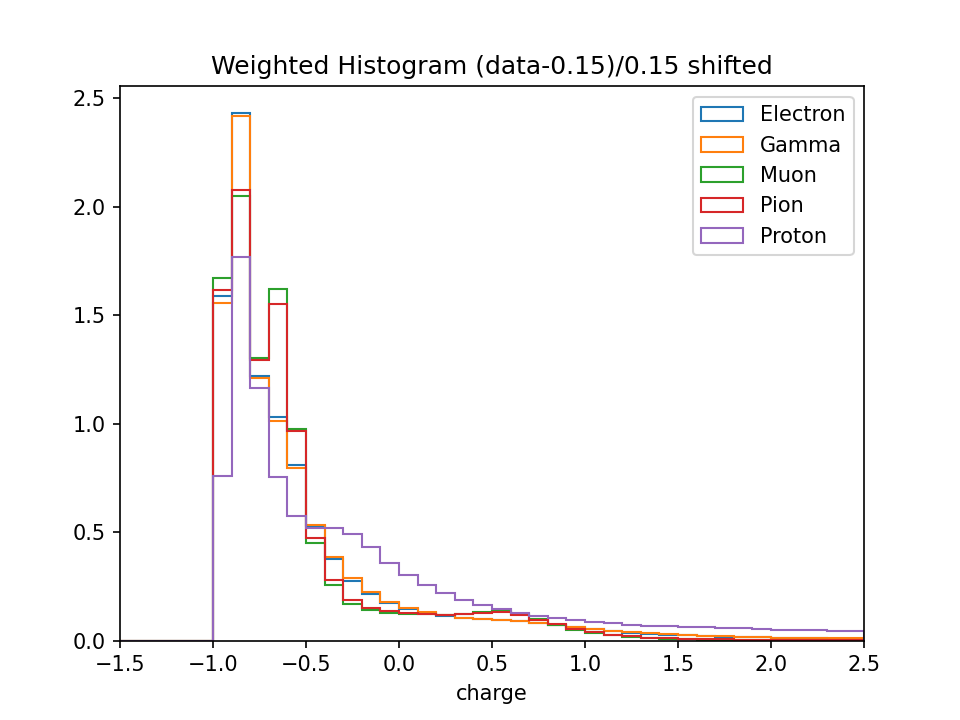

In [16]:
plt.clf()
r = [0.03,0.4]
for i,c in cd.items():
    #if i==2:
    plt.hist(c,histtype='step',label=invclasses[i],bins = 100, range = r, density=True)
    #plt.hist(ctest[i],histtype='step',label=f"p {invclasses[i]}",bins = 100, range = r, density=True)
    plt.xlim(r)
    plt.xlabel("charge")
    plt.title("Histogram Pooled")
    plt.legend()

In [34]:
ctotal = np.array([0])
means=np.zeros(5)
stds=np.zeros(5)
for i,c in cd.items():
    ctotal = np.concatenate((ctotal,c))
for i,c in cd.items():
    print(invclasses[i])
    means[i]=np.median(c[:100000])
    stds[i]=np.std(c[:100000])
    print(means[i])
    print(stds[i])
print("Total")
print(np.median(ctotal))
print(np.std(ctotal))
print("Weighted")
wmeans=np.mean(means)
wstds = np.sqrt(np.sum(stds**2))/np.sqrt(5)
print(wmeans)
print(wstds)

Electron
0.04254150390625
0.0987548828125
Gamma
0.04296875
0.10382080078125
Muon
0.044647216796875
0.07666015625
Pion
0.045928955078125
0.0885009765625
Proton
0.08551025390625
0.33154296875
Total
0.04559326171875
0.14183436158490095
Weighted
0.0523193359375
0.169800605470372


In [33]:
ctotal = np.array([0])
means=np.zeros(5)
stds=np.zeros(5)
cdsq = cd.copy()
for i,c in cdsq.items():
    ctotal = np.concatenate((ctotal,c))
for i,c in cdsq.items():
    cdsq[i]=np.sqrt(c)
for i,c in cdsq.items():
    print(invclasses[i])    
    means[i]=np.median(c[:100000])
    stds[i]=np.std(c[:100000])
    print(means[i])
    print(stds[i])
print("Total")
print(np.median(ctotal))
print(np.std(ctotal))
print("Weighted")
wmeans=np.mean(means)
wstds = np.sqrt(np.sum(stds**2))/np.sqrt(5)
print(wmeans)
print(wstds)

Electron
0.206298828125
0.1368408203125
Gamma
0.207275390625
0.140625
Muon
0.2113037109375
0.11724853515625
Pion
0.21435546875
0.12371826171875
Proton
0.29248046875
0.243896484375
Total
0.04559326171875
0.14183436158490095
Weighted
0.2263427734375
0.15939869704503737


In [35]:
cdnorm = cd.copy()
for x,v in cdnorm.items():
    cdnorm[x]=((v-wmeans)/wstds)

In [36]:
cdsqnorm = cdsq.copy()
for x,v in cdsqnorm.items():
    cdsqnorm[x]=((v-wmeans)/wstds)

In [37]:
plt.clf()
r=[-1.5,2.5]
for i,c in cdsq.items():
        print(np.percentile((c-0.211)/(0.5*0.382)-0.5,5))
        print(np.percentile((c-0.211)/(0.5*0.382)-0.5,95))
        plt.hist((c-0.211)/(0.5*0.382)-0.5,histtype='step',label=invclasses[i],bins=40,range=r,density=True)
        plt.xlabel("charge")
        plt.xlim(r)
        plt.title("Weighted Histogram Sqrt(data) shifted")
        plt.legend()
        plt.show()

-1.046875
1.1767578125
-1.0458984375
1.21484375
-1.0458984375
0.94921875
-1.044921875
0.9794921875
-0.9990234375
2.802734375


In [18]:
plt.clf()
r=[-1.5,2.5]
for i,c in cd.items():
        print(np.percentile((c-0.15)/(0.15),5))
        print(np.percentile((c-0.15)/(0.15),95))
        plt.hist((c-0.15)/(0.15),histtype='step',label=invclasses[i],bins=40,range=r,density=True)
        plt.xlabel("charge")
        plt.xlim(r)
        plt.title("Weighted Histogram (data-0.15)/0.15 shifted")
        plt.legend()
        plt.show()

-0.92431640625
0.8828125
-0.92431640625
0.93798828125
-0.92431640625
0.58837890625
-0.92333984375
0.625
-0.91064453125
3.75


In [14]:
def Plot3d(data_iter,plotsize = (512,512,512)):
    pos3d = data_iter
    fig = go.Figure(data=[go.Scatter3d(
        x=pos3d[:,0],
        y=pos3d[:,1],
        z=pos3d[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color=pos3d[:,3],                # set color to an array/list of desired values
            colorbar=dict(
                title="Charge"
            ),
            colorscale='Viridis',   # choose a colorscale
            opacity=0.9
        )
    )])
    fig.update_layout(
        title=label,
        scene = dict(
            xaxis = dict(nticks=6, range=[0,plotsize[0]]),
            yaxis = dict(nticks=6, range=[0,plotsize[1]]),
            zaxis = dict(nticks=6, range=[0,plotsize[2]]),
            aspectratio=dict(x=1, y=1, z=1)))
    fig.show()
    return 0

Muon


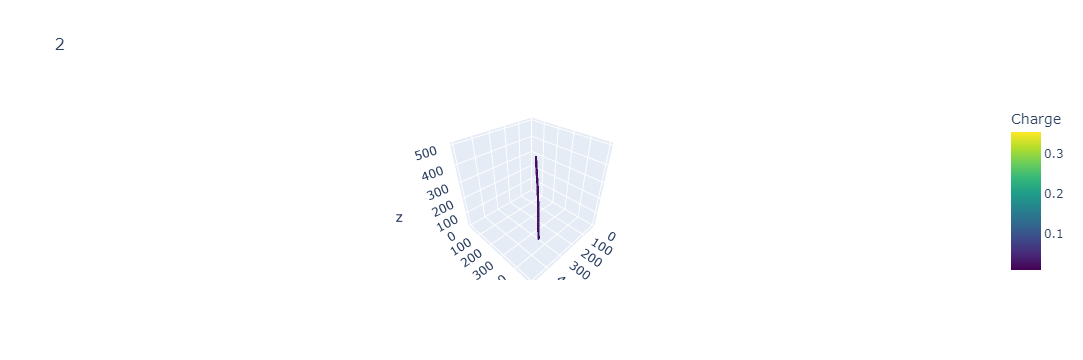

In [28]:
for idx, batch in enumerate(test_loader):
    label = int(batch[1])
# if label == 4:
    print(invclasses[label])
    data = batch[0][0]
    ch = data[:,-1]
    Plot3d(data)
    #pooleddata = pool(full(data))
    #nonzero = torch.nonzero(pooleddata)
    #pooledcharge = torch.unsqueeze(pooleddata[torch.nonzero(pooleddata,as_tuple=True)],1)
    #Plot3d(torch.hstack((nonzero[:,1:4],pooledcharge)),(170,170,170))
#         Plot3d(data[ch<=0.034])
#         Plot3d(data[torch.logical_and(ch<=0.15,ch>0.034)])
#         Plot3d(data[ch>=0.15])
    break